# 2-Sample Tests Power over Increasing Dimension

These are same useful functions to import. Since we are calculating the statistical power over all the tests for all the simulations, we can just use a wild card import from the respective modules

In [27]:
import sys, os
import multiprocessing as mp
from joblib import Parallel, delayed

import numpy as np
import matplotlib.pyplot as plt

from benchmarks import power_2samp_dimension
from hyppo.independence import CCA, Dcorr, HHG, Hsic, RV, MGC
from hyppo.random_forest import MGCRF
from hyppo.sims import *

sys.path.append(os.path.realpath('..'))

In [28]:
import seaborn as sns
sns.set(color_codes=True, style='white', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:5] + PALETTE[6:])

These are some constants that are used in this notebook. If running these notebook, please only manipulate these constants if you are not running more tests. They define the sample sizes tested upon and the number of replications. The simulations tested over and the independence tests tested over are defined also.

In [29]:
# from rpy2.robjects import Formula, numpy2ri
# from rpy2.robjects.packages import importr


# class Manova:
#     r"""
#     Wrapper of R MANOVA
#     """
#     def __init__(self):
#         self.stats = importr('stats')
#         self.r_base = importr('base')
        
#         numpy2ri.activate()

#         self.formula = Formula('X ~ Y')
#         self.env = self.formula.environment

#     def _statistic(self, x, y):
#         r"""
#         Helper function to calculate the test statistic
#         """
#         self.env['Y'] = y
#         self.env['X'] = x

#         stat = self.r_base.summary(self.stats.manova(self.formula), test="Pillai")[3][4]

#         return stat

In [30]:
MAX_DIMENSION = 10
STEP_SIZE = 1
DIMENSIONS = range(1, MAX_DIMENSION + STEP_SIZE, STEP_SIZE)
POWER_REPS = 5

In [38]:
simulations = [
    linear,
    exponential,
    cubic,
    joint_normal,
    step,
    quadratic,
    w_shaped,
    spiral,
    uncorrelated_bernoulli,
    logarithmic,
    fourth_root,
    sin_four_pi,
    sin_sixteen_pi,
    square,
    two_parabolas,
    circle,
    ellipse,
#     diamond,
#     multiplicative_noise,
#     multimodal_independence
]

tests = [
    MGCRF,
    CCA,
    MGC,
    RV,
    Dcorr,
    Hsic,
    HHG,
]

In [32]:
# def find_dim(sim):
#     if sim not in simulations:
#         raise ValueError("Invalid simulation")
        
#     if sim in [joint_normal, sin_four_pi, sin_sixteen_pi, multiplicative_noise]:
#         dim = 10
#     elif sim in [multimodal_independence, uncorrelated_bernoulli, logarithmic]:
#         dim = 100
#     elif sim in [linear, exponential, cubic]:
#         dim = 1000
#     elif sim in [square, diamond]:
#         dim = 40
#     else:
#         dim = 20
        
#     return dim

# def find_dim_range(dim):
#     if dim < 20:
#         lim = 10
#     else:
#         lim = 20
    
#     dim_range = list(range(int(dim/lim), dim+1, int(dim/lim)))
#     if int(dim/lim) != 1:
#         dim_range.insert(0, 1)
#     return dim_range

The following function calculates the estimated power ``POWER_REPS`` number off times and averages them. It does this iterating over the number of sample sizes.

**Note: We only recommend running this code if running the next 2 cells ONCE to generate the csv files used to visualize the plots. This code takes a very long time to run and if running, we recommend using a machine with many cores.**

In [6]:
def estimate_power(sim, test):
    dim = find_dim(sim)
    dim_range = find_dim_range(dim)
    est_power = np.array([np.mean([power_2samp_dimension(test, trans_2samp, sim, p=dim) for _ in range(POWER_REPS)])
                          for dim in dim_range])
    if test.__name__ == "Dcorr":
        np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, "Energy"),
               est_power, delimiter=',')
    elif test.__name__ == "Hsic":
        np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, "MMD"),
               est_power, delimiter=',')
    else:
        np.savetxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                   est_power, delimiter=',')
    
    return est_power

In [7]:
outputs = Parallel(n_jobs=-1, verbose=100)(
    [delayed(estimate_power)(sim, test) for sim in simulations for test in tests]
)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 96 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed: 1323.7min
[Parallel(n_jobs=-1)]: Done   2 out of  20 | elapsed: 1376.3min remaining: 12386.8min
[Parallel(n_jobs=-1)]: Done   3 out of  20 | elapsed: 1427.6min remaining: 8089.8min
[Parallel(n_jobs=-1)]: Done   4 out of  20 | elapsed: 1442.0min remaining: 5767.9min
[Parallel(n_jobs=-1)]: Done   5 out of  20 | elapsed: 1446.4min remaining: 4339.3min
[Parallel(n_jobs=-1)]: Done   6 out of  20 | elapsed: 1467.2min remaining: 3423.5min
[Parallel(n_jobs=-1)]: Done   7 out of  20 | elapsed: 1482.7min remaining: 2753.5min
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed: 1493.0min remaining: 2239.4min
[Parallel(n_jobs=-1)]: Done   9 out of  20 | elapsed: 1499.9min remaining: 1833.2min
[Parallel(n_jobs=-1)]: Done  10 out of  20 | elapsed: 1640.3min remaining: 1640.3min
[Parallel(n_jobs=-1)]: Done  11 out of  20 | elapsed: 1651.6min remaining: 1351.3min
[Paralle

The following code loops over each saved independence test file and generates absolute power curves for each test and for each simulation modality.

In [49]:
def plot_power():
    fig, ax = plt.subplots(nrows=4, ncols=5, figsize=(18,18))
    
    sim_title = [
        "Linear",
        "Exponential",
        "Cubic",
        "Joint Normal",
        "Step",
        "Quadratic",
        "W-Shaped",
        "Spiral",
        "Bernoulli",
        "Logarithmic",
        "Fourth Root",
        "Sine 4\u03C0",
        "Sine 16\u03C0",
        "Square",
        "Two Parabolas",
        "Circle",
        "Ellipse",
        "Diamond",
        "Multiplicative",
        "Independence"
    ]
    
    for i, row in enumerate(ax):
        for j, col in enumerate(row):
            count = 5*i + j
            sim = simulations[count]
            
            for test in tests:
                power = np.genfromtxt('../benchmarks/2samp_vs_dimension/{}_{}.csv'.format(sim.__name__, test.__name__),
                                      delimiter=',')
                
                custom_color = {
                    "Energy" : "#377eb8",
                    "MMD" : "#4daf4a",
                    "MGC" : "#e41a1c",
                    "MGCRF" : "#e41a1c",
                }
                if test.__name__ in custom_color.keys():
                    if test.__name__ == "MGC":
                        col.plot(DIMENSIONS, power, custom_color[test.__name__], label=test.__name__, lw=5)
                    if test.__name__ == "Dcorr":
                        col.plot(DIMENSIONS, power, custom_color["Energy"], label="Energy", lw=2)
                    if test.__name__ == "Hsic":
                        col.plot(DIMENSIONS, power, custom_color["MMD"], label="MMD", lw=2)
                    elif test.__name__ == "MGCRF":
                        col.plot(DIMENSIONS, power, custom_color[test.__name__], label=test.__name__, lw=5, linestyle='dashed')
                    else:
                        col.plot(DIMENSIONS, power, custom_color[test.__name__], label=test.__name__, lw=2)
                else:
                    col.plot(DIMENSIONS, power, label=test.__name__, lw=2)
                col.set_xticks([])
                if i == 3:
                    col.set_xticks([DIMENSIONS[0], DIMENSIONS[-1]])
                col.set_ylim(-0.05, 1.05)
                col.set_yticks([])
                if j == 0:
                    col.set_yticks([0, 1])
                col.set_title(sim_title[count])
    
    fig.text(0.5, 0.08, 'Dimension', ha='center')
    fig.text(0.08, 0.5, 'Statistical Power', va='center', rotation='vertical')
    leg = plt.legend(bbox_to_anchor=(0.5, 0.08), bbox_transform=plt.gcf().transFigure,
                     ncol=5, loc='upper center')
    leg.get_frame().set_linewidth(0.0)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(5.0)
    plt.subplots_adjust(hspace=.50)
    plt.savefig('../benchmarks/figs/2samp_power_dimension.pdf', transparent=True, bbox_inches='tight')

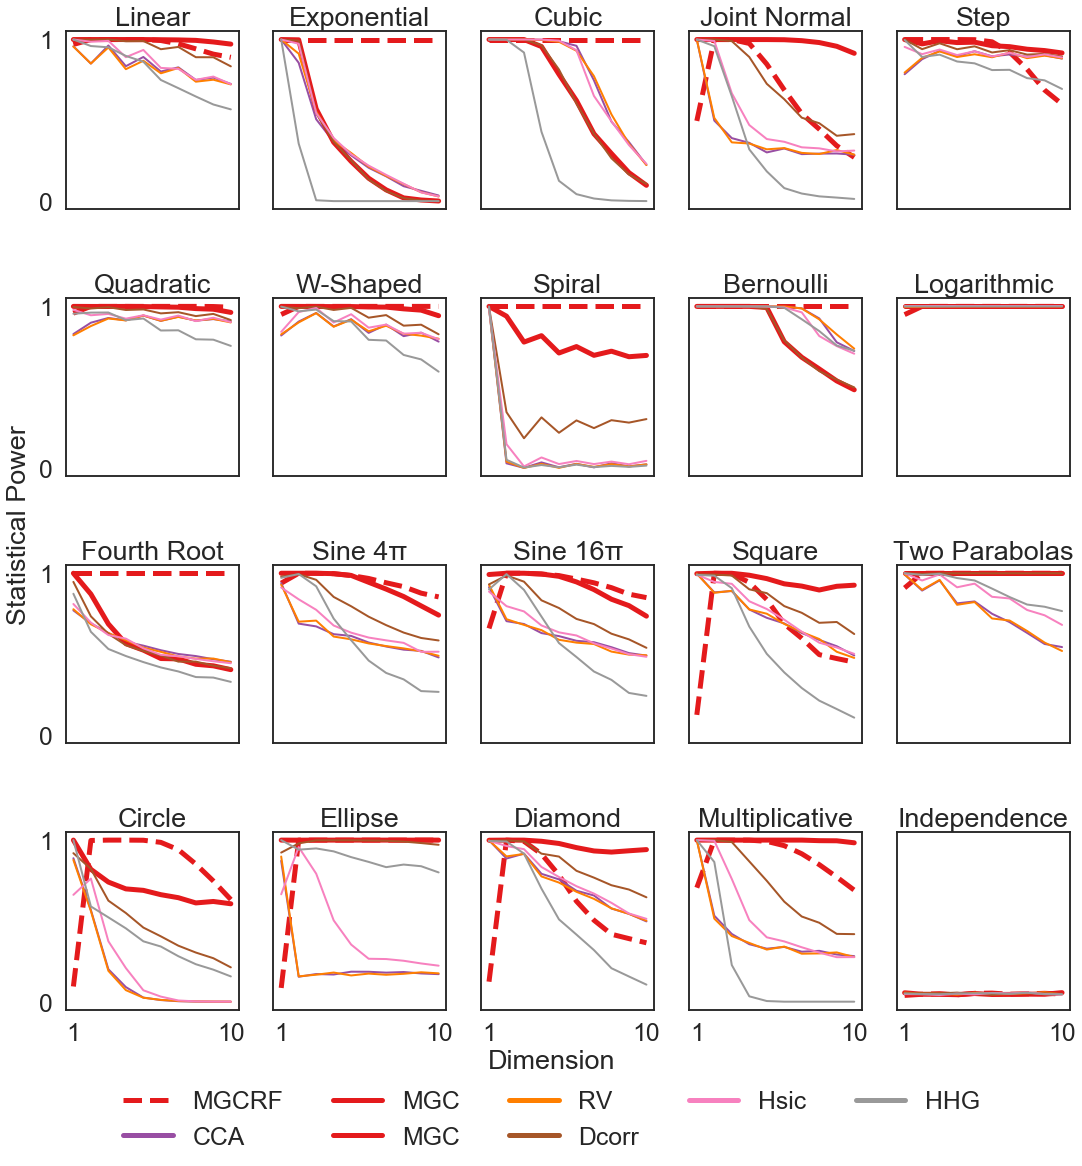

In [50]:
plot_power()